Simulation of Melagen Ground Station

In [53]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import re
from datetime import datetime, timezone
# generate random sample
# 7200 samples x 26 bytes = 187200 bytes
# packet structure: [D1R1][D1R2][D2R1][D2R2][D3R1][D3R2][D4R1][D4R2][D5R1][D5R2][CRC]
# 7200 samples x 22 bytes = 158400 bytes
# (7200 x 22) / 64 = 2475 blocks

# using 0x80040000 to 0x80080000 uses 262144 bytes
# 262144 / (1440 x 22) = 8.274 days worth of data stored

# a data frame with each observation will have dose and sensor label

# ---------------- Constants  ----------------
ADC_REF = 2500  # mV
ADC_MAX_VAL = 2048 - 1
ADC_TO_MV = ADC_REF / ADC_MAX_VAL  # mV per count

R1 = 243_000  # divider R1 (ohms)
R2 = 200_000  # divider R2 (ohms)

SENSOR_WEIGHTS = {"D1": 0.5, "D2": 0.7, "D3": 1.0, "D4": 1.3, "D5": 1.5}

# ---------------- Helpers ----------------
def crc16_ccitt(data_bytes: bytes, poly=0x1021, init=0xFFFF) -> int:
    crc = init
    for b in data_bytes:
        crc ^= (b << 8)
        for _ in range(8):
            crc = ((crc << 1) ^ poly) & 0xFFFF if (crc & 0x8000) else ((crc << 1) & 0xFFFF)
    return crc

def pack_le_u16(v: int) -> bytes:
    return bytes((v & 0xFF, (v >> 8) & 0xFF))

def pack_le_u32(v: int) -> bytes:
    return bytes((v & 0xFF, (v >> 8) & 0xFF, (v >> 16) & 0xFF, (v >> 24) & 0xFF))

def actual_voltage(Vout, r1=R1, r2=R2):
    # Vout = Vin * (r2 / (r1 + r2))  => Vin = Vout / (r2/(r1 + r2))
    return Vout / (r2 / (r1 + r2))

def dose_from_V(V, A=0.02951, B=0.45509):
    # V = A * Dose^B  => Dose = (V/A)^(1/B)
    return (V / A) ** (1.0 / B)

# ---------------- Packet generation ----------------
def generate_packet_correlated(index: int,
                               base_min=500,
                               base_max=ADC_MAX_VAL,
                               noise_sigma_pct=0.02,
                               rho=0.01):
    """
    Returns a structured dict with:
      sample_index, d1_r1..d5_r2, crc16
    CRC16 is computed over [index(4B LE)] + 10x int16 LE.
    """
    readings = []
    # Generate 10 ADC counts (D1..D5 x R1/R2)
    for s in range(1, 6):
        key = f"D{s}"
        w = SENSOR_WEIGHTS[key]
        base = int(random.randint(base_min, base_max) * w)
        base = max(0, min(base, ADC_MAX_VAL))

        sigma = max(1, int(base * noise_sigma_pct))
        common = int(random.gauss(0, sigma))
        indep1 = int(random.gauss(0, sigma))
        indep2 = int(random.gauss(0, sigma))

        r1c = base + int(rho * common + (1 - rho) * indep1)
        r2c = base + int(rho * common + (1 - rho) * indep2)

        readings.extend([max(0, min(r1c, ADC_MAX_VAL)),
                         max(0, min(r2c, ADC_MAX_VAL))])

    # Build bytes to CRC: index LE + 10 * int16 LE
    payload = bytearray()
    payload += pack_le_u32(index)
    for v in readings:
        payload += pack_le_u16(v & 0xFFFF)
    crc = crc16_ccitt(payload)

    # Return both numeric fields and CRC
    fields = {
        "sample_index": index,
        "d1_r1": readings[0],  "d1_r2": readings[1],
        "d2_r1": readings[2],  "d2_r2": readings[3],
        "d3_r1": readings[4],  "d3_r2": readings[5],
        "d4_r1": readings[6],  "d4_r2": readings[7],
        "d5_r1": readings[8],  "d5_r2": readings[9],
        "crc16": crc
    }
    return fields

def make_csv_rows(num_packets=100, start_index=0, add_rx_utc=True):
    """
    Produces a DataFrame matching the agreed CSV schema:
      request_utc, sample_index, d1_r1..d5_r2, crc16_ok, rx_utc(optional)
    """
    request_utc = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")
    rows = []
    for i in range(start_index, start_index + num_packets):
        pkt = generate_packet_correlated(i)

        # Recompute CRC as OBC would, to set crc16_ok
        payload = bytearray()
        payload += pack_le_u32(pkt["sample_index"])
        for key in ("d1_r1","d1_r2","d2_r1","d2_r2","d3_r1","d3_r2","d4_r1","d4_r2","d5_r1","d5_r2"):
            payload += pack_le_u16(int(pkt[key]) & 0xFFFF)
        crc_check = crc16_ccitt(payload)
        crc_ok = (crc_check == pkt["crc16"])

        row = {
            "request_utc": request_utc,
            "sample_index": pkt["sample_index"],
            "d1_r1": pkt["d1_r1"], "d1_r2": pkt["d1_r2"],
            "d2_r1": pkt["d2_r1"], "d2_r2": pkt["d2_r2"],
            "d3_r1": pkt["d3_r1"], "d3_r2": pkt["d3_r2"],
            "d4_r1": pkt["d4_r1"], "d4_r2": pkt["d4_r2"],
            "d5_r1": pkt["d5_r1"], "d5_r2": pkt["d5_r2"],
            "crc16_ok": crc_ok
        }
        if add_rx_utc:
            row["rx_utc"] = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")
        rows.append(row)
    return pd.DataFrame(rows)

# ---------------- Analysis frame (keeps your voltage/dose work) ----------------
def expand_for_analysis(df_csv_like: pd.DataFrame) -> pd.DataFrame:
    """
    Long-form expansion: one row per sensor/rail per packet with voltages and dose.
    """
    records = []
    for _, row in df_csv_like.iterrows():
        for s in range(1, 6):
            for r in (1, 2):
                key = f"d{s}_r{r}"
                adc = int(row[key])
                mv = adc * ADC_TO_MV
                vout = mv / 1000.0
                vin = actual_voltage(vout, R1, R2)
                dose = dose_from_V(vin)
                records.append({
                    "sample_index": int(row["sample_index"]),
                    "sensor": f"D{s}R{r}",
                    "adc_value": adc,
                    "voltage_mV": mv,
                    "voltage_V": vout,
                    "voltage_actual": vin,
                    "dose 0-100k": dose,
                })
    return pd.DataFrame.from_records(records)

# ---------------- Example usage ----------------
# CSV-like, per the ICD
csv_df = make_csv_rows(num_packets=100, start_index=10_000, add_rx_utc=True)
# csv_df.to_csv("MELAGEN_OOS-1_2025-09-27T19-43-12Z_00010000-00010099_v1.csv", index=False)

# Optional: analysis-friendly expansion
df = expand_for_analysis(csv_df)
df.head()


,sample_index,sensor,adc_value,voltage_mV,voltage_V,voltage_actual,dose 0-100k
0,10000,D1R1,940,1148.021495,1.148021,2.542868,17893.086957
1,10000,D1R2,934,1140.693698,1.140694,2.526637,17643.081613
2,10000,D2R1,404,493.404983,0.493405,1.092892,2797.746997
3,10000,D2R2,420,512.945774,0.512946,1.136175,3047.007127
4,10000,D3R1,1405,1715.925745,1.715926,3.800776,43274.535849


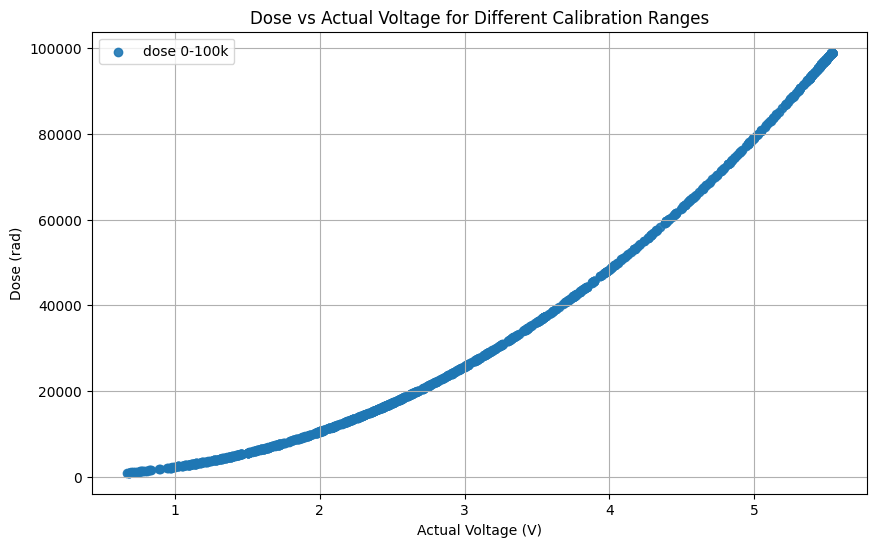

In [54]:
plt.figure(figsize=(10, 6))

dose_columns = ["dose 0-100k"]#, "dose 0-50k", "dose 0-10k", "dose 0-5k", "dose 0-1k"]
for col in dose_columns:
    plt.scatter(df["voltage_actual"], df[col], label=col, alpha=0.9)

plt.xlabel("Actual Voltage (V)")
plt.ylabel("Dose (rad)")
plt.title("Dose vs Actual Voltage for Different Calibration Ranges")
plt.legend()
plt.grid(True)
plt.show()

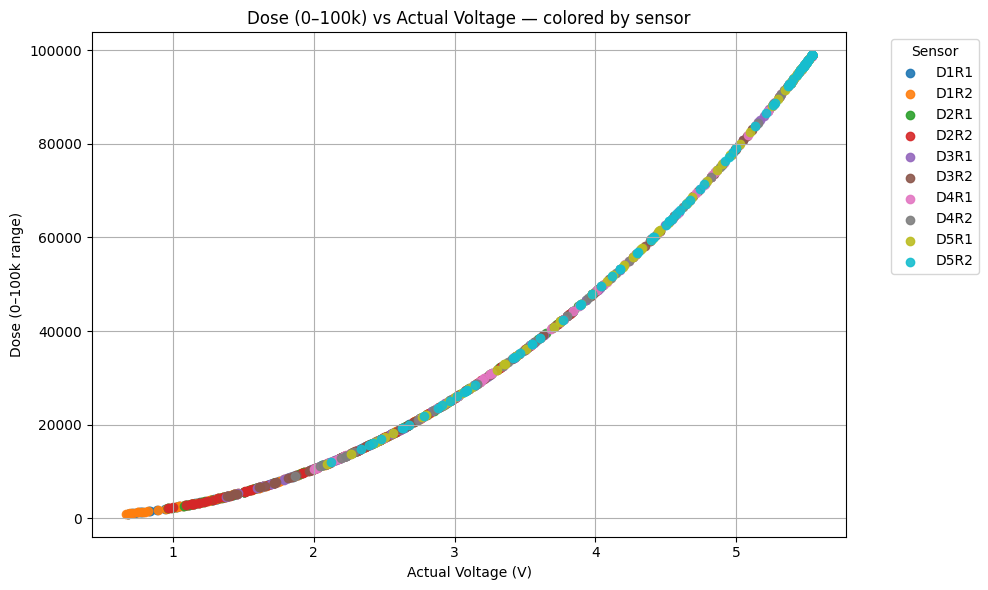

In [55]:
plt.figure(figsize=(10, 6))

for sensor, grp in df.groupby("sensor"):
    plt.scatter(grp["voltage_actual"], grp["dose 0-100k"], label=sensor, alpha=0.9)

plt.xlabel("Actual Voltage (V)")
plt.ylabel("Dose (0–100k range)")
plt.title("Dose (0–100k) vs Actual Voltage — colored by sensor")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

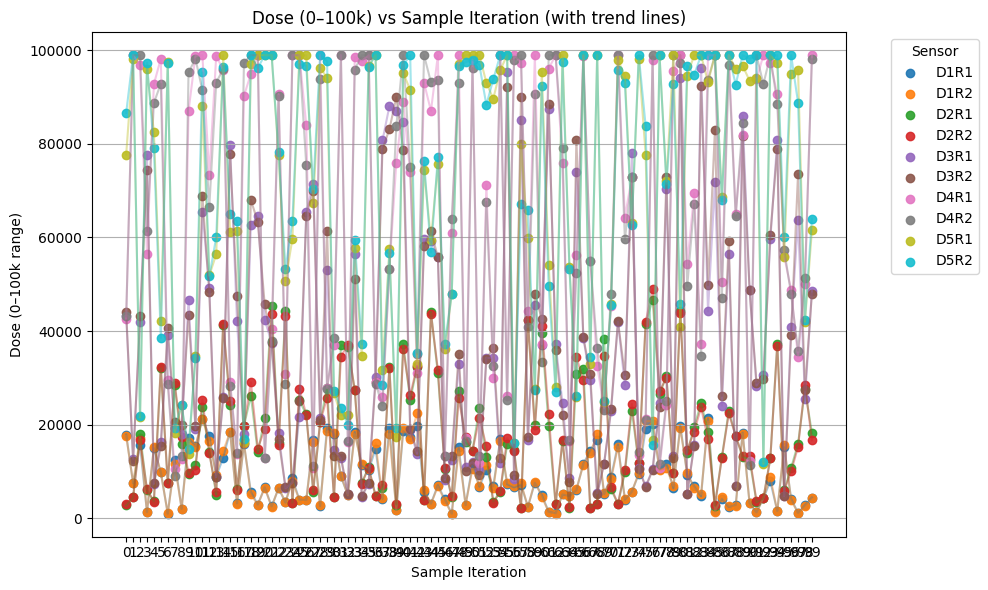

In [56]:
df = df.copy()
df["iteration"] = df.index // 10  # integer division: each 10 values = 1 iteration

plt.figure(figsize=(10, 6))

for sensor, grp in df.groupby("sensor"):
    # scatter points
    plt.scatter(grp["iteration"].astype(str),
                grp["dose 0-100k"],
                label=sensor, alpha=0.9)

    # trend line (sorted by iteration)
    grp_sorted = grp.sort_values("iteration")
    plt.plot(grp_sorted["iteration"].astype(str),
             grp_sorted["dose 0-100k"],
             alpha=0.4)  # semi-transparent line

plt.xlabel("Sample Iteration")
plt.ylabel("Dose (0–100k range)")
plt.title("Dose (0–100k) vs Sample Iteration (with trend lines)")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

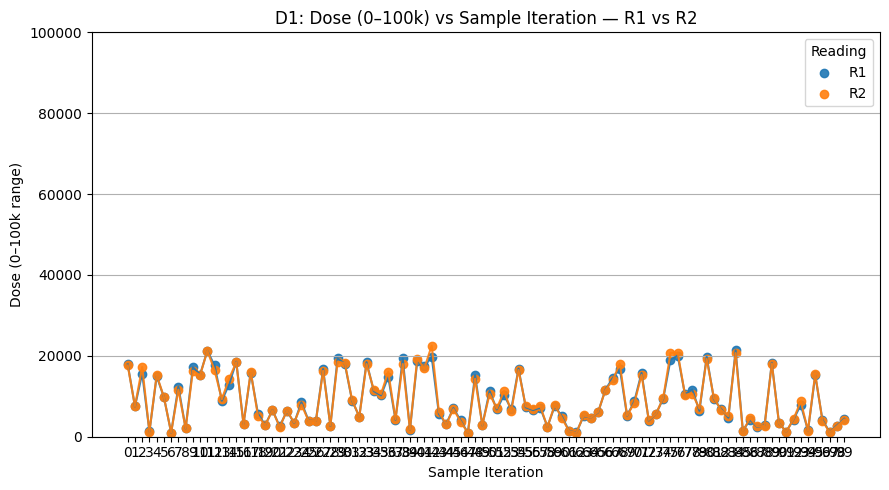

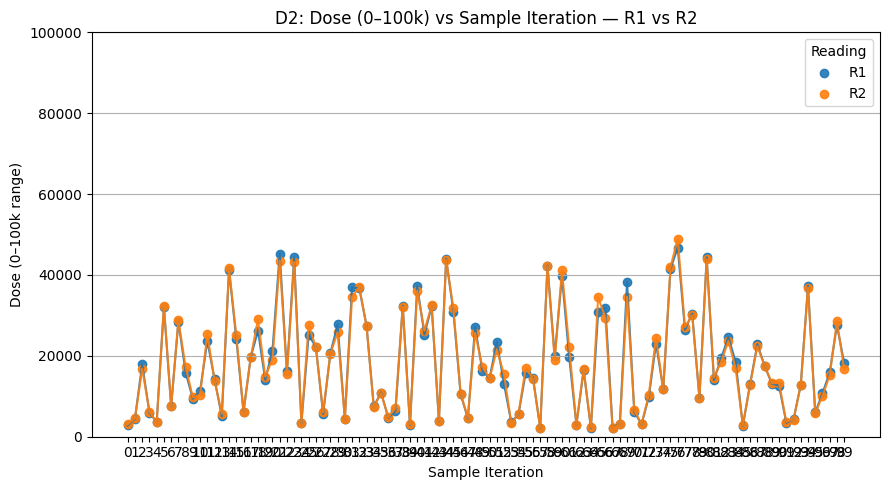

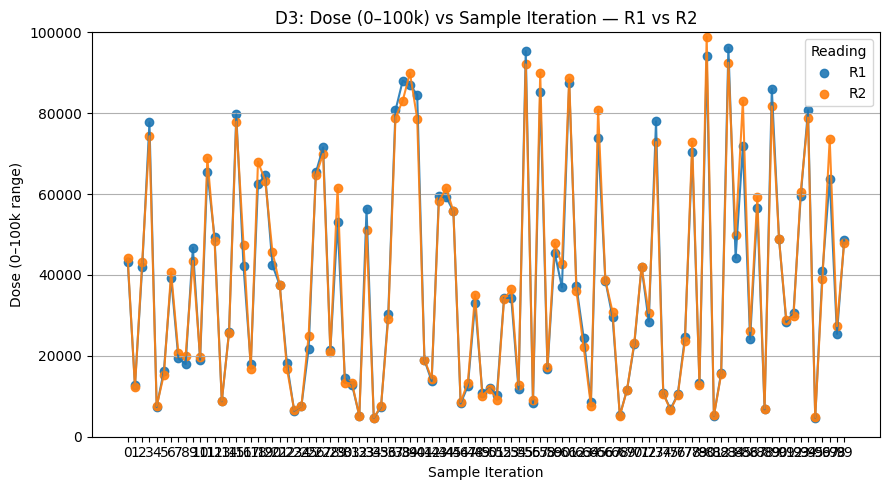

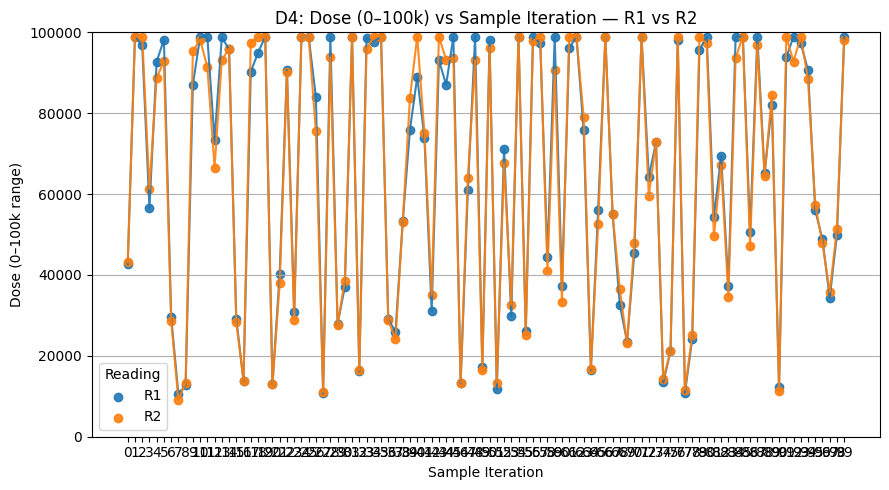

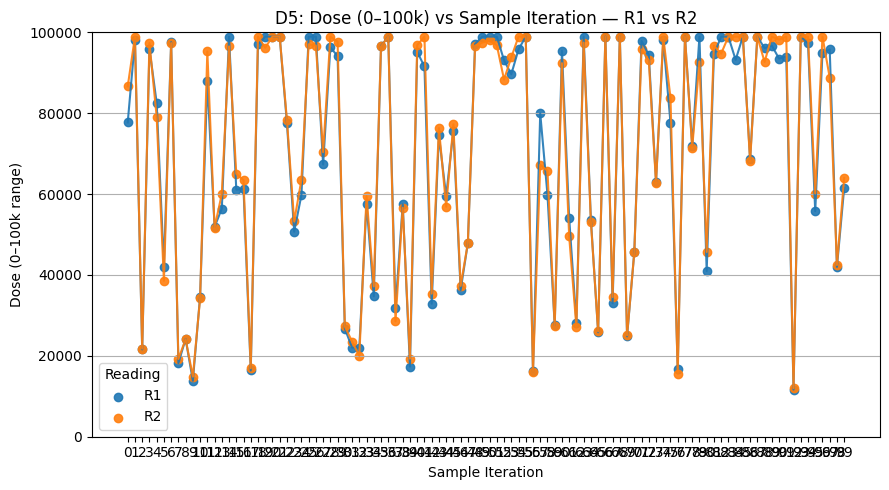

In [57]:

# Ensure dataframe `df` exists
if 'df' not in globals():
    raise RuntimeError("Dataframe `df` not found. Please run the previous cell that constructs `df` first.")

# Ensure iteration column exists
if "iteration" not in df.columns:
    df = df.copy()
    df["iteration"] = df.index // 10  # every 10 rows = 1 iteration

# Parse base sensor (D1..D5) and reading id (R1/R2) from "sensor" like "D3R2"
df = df.copy()
df["base_sensor"] = df["sensor"].str.extract(r"(D\d)R[12]")
df["read_id"] = df["sensor"].str.extract(r"D\d(R[12])")

# Iterate each base sensor and make a separate figure
for base in sorted(df["base_sensor"].unique(), key=lambda x: int(x[1:])):
    sub = df[df["base_sensor"] == base].sort_values(["iteration", "read_id"])

    plt.figure(figsize=(9, 5))
    # Plot R1 and R2 as separate series
    for rid, grp in sub.groupby("read_id"):
        # Use categorical x to keep it discrete
        xcat = grp["iteration"].astype(str)
        y = grp["dose 0-100k"]
        plt.scatter(xcat, y, label=rid, alpha=0.9)
        # Connect same R* across iterations to show trend
        # Sort by numeric iteration for the line
        g2 = grp.sort_values("iteration")
        plt.plot(g2["iteration"].astype(str), g2["dose 0-100k"], alpha=0.9)

    plt.xlabel("Sample Iteration")
    plt.ylabel("Dose (0–100k range)")
    plt.title(f"{base}: Dose (0–100k) vs Sample Iteration — R1 vs R2")
    plt.legend(title="Reading")
    plt.grid(True, axis="y")
    plt.ylim(0, 100000) 
    plt.tight_layout()
    plt.show()

In [58]:
# check for new csv packets (forever?) (every)
# take in data from partners 
# maybe in csv format?
# extrapolate samples from 26 byte packets
# if the crc isnt valid, disregard sample
# if valid samples have the same index and data, its a repeated sample, also disregard to not skew statistical analysis
# if valid samples have the same index but different data, and they both have a valid checksum, we'll know that there was a reset and the metadata wasnt loaded properly
# create dataframe from data and perform analysis